In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import imageio

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


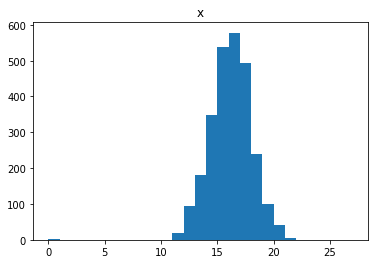

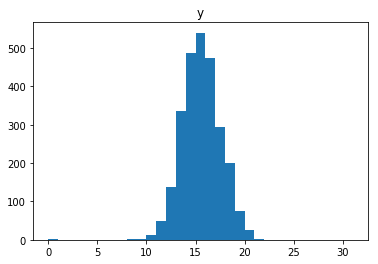

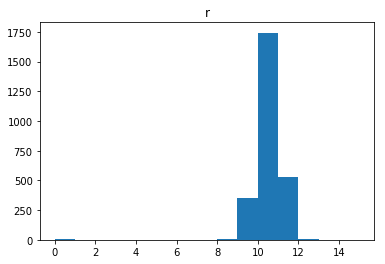

(2639, 1, 1, 280, 320)
(2639, 3, 1)


In [3]:
#load images
import glob

def load_pics():
    pics = glob.glob('CASIA-Iris-Interval/**/*.jpg', recursive=True)

    X = []
    names = []
    for pic in pics:
        f = imageio.imread(pic)/255.0
        X.append(f)
        names.append(pic[-12:])
    
    X = np.array(X)
    return X, names

#load annotations
def load_annotations(X, order):
    N = X.shape[0]
    f = open('CASIA-Iris-V3-Labels.txt')
    y_trunc = np.zeros((N, 3)) 
    y_true = np.zeros((N,3))
    for l in f:
        l = l.strip().split(' ')
        name, a, b, c = l[0], int(l[1]), int(l[2]), int(l[3])
        i = order.index(name)
        y_true[i] += np.array([a, b, c])
        y_trunc[i] += np.array([a // 10, b // 10, c // 10])
    return y_true, y_trunc
    
X, order = load_pics()
Xt = np.array(X).reshape((X.shape[0], 1, 1, X.shape[1], X.shape[2]))
y_true, y = load_annotations(X, order)

plt.hist(y[:,0], bins=range(28))
plt.title('x')
plt.show()

plt.hist(y[:,1], bins=range(32))
plt.title('y')
plt.show()

plt.hist(y[:,2], bins=range(16))
plt.title('r')
plt.show()

yt = y.reshape((y.shape[0], y.shape[1], 1))

print(Xt.shape)
print(yt.shape)

In [4]:
N = Xt.shape[0]
train = int(6*N/10)
val = int(7*N/10)
X_train = Xt[:train]
X_val = Xt[train:val]
X_test = Xt[val:]

y_train = yt[:train]
y_train_true = y_true[:train]

y_val = yt[train:val]
y_val_true = y_true[train:val]

y_test = yt[val:]
y_test_true = y_true[val:]

X_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_val = torch.tensor(y_val)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

torch.Size([1583, 1, 1, 280, 320])
torch.Size([1583, 3, 1])
torch.Size([264, 1, 1, 280, 320])
torch.Size([264, 3, 1])


In [5]:
def check_accuracy_part34(mode, model, param):
    
    def assign_param(param, y_generic):
        if param == 'x':
            return y_generic[:,0]
        elif param == 'y':
            return y_generic[:,1]
        else:
            return y_generic[:,2]
    
    if mode == 'val':
        X_sel = X_val
        y_sel = assign_param(param, y_val)
    elif mode == 'train':
        X_sel = X_train
        y_sel = assign_param(param, y_train)
    else:
        X_sel = X_test
        y_sel = assign_param(param, y_test)
        
    SE = 0.0
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #SE += (x_center.data[0][0] - y) ** 2
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))
        #print(('RMSE ->', SE))

In [6]:
def train_part34(model, optimizer, param, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    if param == 'x':
        y_sel = y_train[:,0]
    elif param == 'y':
        y_sel = y_train[:,1]
    else:
        y_sel = y_train[:,2]
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #for t, (x, y) in enumerate(training_data):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #loss = F.mse_loss(x_center[0][0], y)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model, param)
        check_accuracy_part34('val', model, param)
        print() 

In [7]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [9]:
channel_1 = 32
channel_2 = 16

model_x = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 28)
)

model_y = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 32)
)

model_r = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 14)
)

optimizer_x = optim.SGD(model_x.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_y = optim.SGD(model_y.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_r = optim.SGD(model_r.parameters(), lr=1e-4, momentum=0.9, nesterov=True)

print('Train X Position')
train_part34(model_x, optimizer_x, 'x', epochs=70)

print('Train Y Position')
train_part34(model_y, optimizer_y, 'y', epochs=70)

print('Train Radius')
train_part34(model_r, optimizer_r, 'r', epochs=50)

Train X Position
Iteration 0, loss = 3.2218

Iteration 500, loss = 1.8991

Iteration 1000, loss = 1.4598

Iteration 1500, loss = 1.1930

epoch 0
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5953

Iteration 500, loss = 1.7586

Iteration 1000, loss = 1.4321

Iteration 1500, loss = 1.1614

epoch 1
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5561

Iteration 500, loss = 1.7058

Iteration 1000, loss = 1.4192

Iteration 1500, loss = 1.1531

epoch 2
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5361

Iteration 500, loss = 1.6672

Iteration 1000, loss = 1.4060

Iteration 1500, loss = 1.1445

epoch 3
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5133

Iteration 500, loss = 1.6272

Iteration 1000, loss = 1.3805

Iteration 1500, loss = 1.1

Iteration 1500, loss = 0.2119

epoch 37
Got 1220 / 1583 correct (77.07) for mode train
Got 185 / 264 correct (70.08) for mode val

Iteration 0, loss = 0.2981

Iteration 500, loss = 0.2025

Iteration 1000, loss = 0.0165

Iteration 1500, loss = 0.2083

epoch 38
Got 1223 / 1583 correct (77.26) for mode train
Got 187 / 264 correct (70.83) for mode val

Iteration 0, loss = 0.2836

Iteration 500, loss = 0.2010

Iteration 1000, loss = 0.0153

Iteration 1500, loss = 0.1970

epoch 39
Got 1226 / 1583 correct (77.45) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.2797

Iteration 500, loss = 0.1954

Iteration 1000, loss = 0.0138

Iteration 1500, loss = 0.1883

epoch 40
Got 1230 / 1583 correct (77.70) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.2629

Iteration 500, loss = 0.1840

Iteration 1000, loss = 0.0129

Iteration 1500, loss = 0.1839

epoch 41
Got 1232 / 1583 correct (77.83) for mode train
Got 188 / 264 correct (71.21) for

Iteration 500, loss = 1.4854

Iteration 1000, loss = 1.1262

Iteration 1500, loss = 2.4550

epoch 5
Got 582 / 1583 correct (36.77) for mode train
Got 93 / 264 correct (35.23) for mode val

Iteration 0, loss = 0.6803

Iteration 500, loss = 1.4443

Iteration 1000, loss = 1.0149

Iteration 1500, loss = 2.5889

epoch 6
Got 716 / 1583 correct (45.23) for mode train
Got 105 / 264 correct (39.77) for mode val

Iteration 0, loss = 0.4818

Iteration 500, loss = 1.3917

Iteration 1000, loss = 0.8929

Iteration 1500, loss = 2.6652

epoch 7
Got 842 / 1583 correct (53.19) for mode train
Got 124 / 264 correct (46.97) for mode val

Iteration 0, loss = 0.3379

Iteration 500, loss = 1.3491

Iteration 1000, loss = 0.7643

Iteration 1500, loss = 2.6553

epoch 8
Got 944 / 1583 correct (59.63) for mode train
Got 146 / 264 correct (55.30) for mode val

Iteration 0, loss = 0.2409

Iteration 500, loss = 1.3331

Iteration 1000, loss = 0.6541

Iteration 1500, loss = 2.5858

epoch 9
Got 995 / 1583 correct (62.86

Got 1267 / 1583 correct (80.04) for mode train
Got 191 / 264 correct (72.35) for mode val

Iteration 0, loss = 0.0305

Iteration 500, loss = 1.6827

Iteration 1000, loss = 0.0567

Iteration 1500, loss = 0.9049

epoch 43
Got 1271 / 1583 correct (80.29) for mode train
Got 192 / 264 correct (72.73) for mode val

Iteration 0, loss = 0.0300

Iteration 500, loss = 1.6875

Iteration 1000, loss = 0.0545

Iteration 1500, loss = 0.8828

epoch 44
Got 1273 / 1583 correct (80.42) for mode train
Got 191 / 264 correct (72.35) for mode val

Iteration 0, loss = 0.0296

Iteration 500, loss = 1.6708

Iteration 1000, loss = 0.0522

Iteration 1500, loss = 0.8620

epoch 45
Got 1275 / 1583 correct (80.54) for mode train
Got 191 / 264 correct (72.35) for mode val

Iteration 0, loss = 0.0300

Iteration 500, loss = 1.6681

Iteration 1000, loss = 0.0505

Iteration 1500, loss = 0.8401

epoch 46
Got 1279 / 1583 correct (80.80) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0291

I

Iteration 500, loss = 0.2063

Iteration 1000, loss = 1.9611

Iteration 1500, loss = 0.0604

epoch 10
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1706

Iteration 500, loss = 0.2089

Iteration 1000, loss = 1.9544

Iteration 1500, loss = 0.0623

epoch 11
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1728

Iteration 500, loss = 0.2108

Iteration 1000, loss = 1.9489

Iteration 1500, loss = 0.0640

epoch 12
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1781

Iteration 500, loss = 0.2119

Iteration 1000, loss = 1.9442

Iteration 1500, loss = 0.0655

epoch 13
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1884

Iteration 500, loss = 0.2123

Iteration 1000, loss = 1.9437

Iteration 1500, loss = 0.0670

epoch 14
Got 1078 / 1583 cor

Iteration 1500, loss = 0.0444

epoch 47
Got 1126 / 1583 correct (71.13) for mode train
Got 170 / 264 correct (64.39) for mode val

Iteration 0, loss = 3.1237

Iteration 500, loss = 0.2610

Iteration 1000, loss = 2.0631

Iteration 1500, loss = 0.0456

epoch 48
Got 1127 / 1583 correct (71.19) for mode train
Got 170 / 264 correct (64.39) for mode val

Iteration 0, loss = 3.1177

Iteration 500, loss = 0.2706

Iteration 1000, loss = 2.0685

Iteration 1500, loss = 0.0427

epoch 49
Got 1132 / 1583 correct (71.51) for mode train
Got 171 / 264 correct (64.77) for mode val



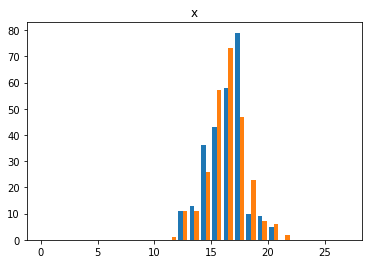

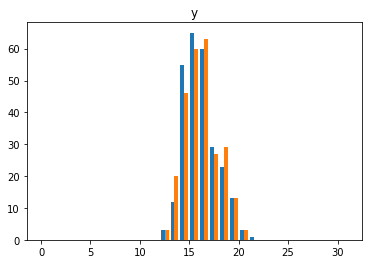

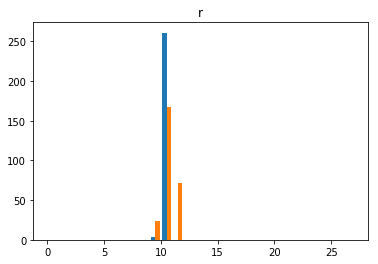

In [10]:
scores_x = model_x(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_x = np.array(scores_x.data)
y_pred_val_x = np.argmax(scores_nparr_x, axis=1)
plt.hist([y_pred_val_x, y_val[:,0]], bins=range(28))
plt.title('x')
plt.show()

scores_y = model_y(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_y = np.array(scores_y.data)
y_pred_val_y = np.argmax(scores_nparr_y, axis=1)
plt.hist([y_pred_val_y, y_val[:,1]], bins=range(32))
plt.title('y')
plt.show()

scores_r = model_r(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_r = np.array(scores_r.data)
y_pred_val_r = np.argmax(scores_nparr_r, axis=1)
plt.hist([y_pred_val_r, y_val[:,2]], bins=range(28))
plt.title('r')
plt.show()

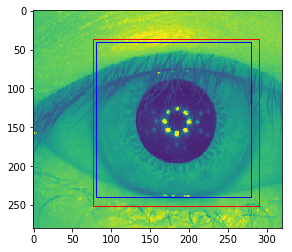

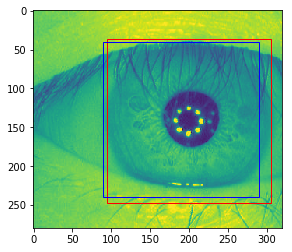

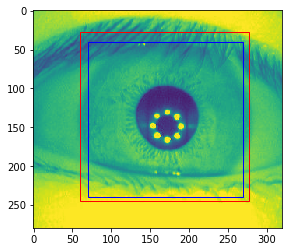

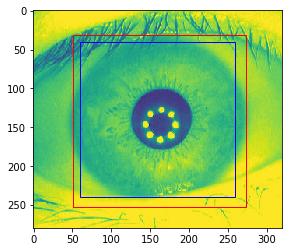

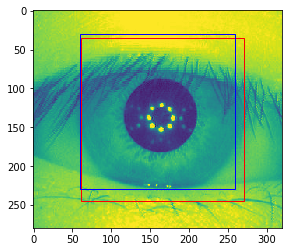

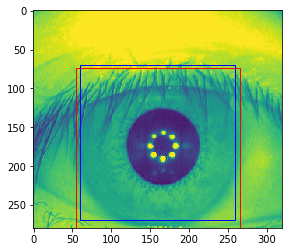

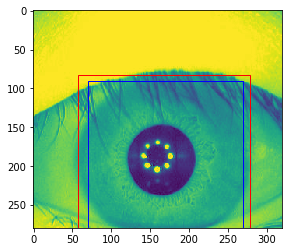

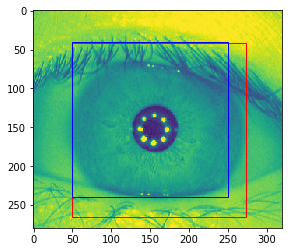

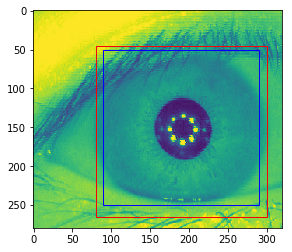

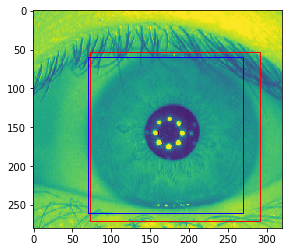

In [11]:
#im = np.array(Image.open('CASIA-Iris-Interval/001/L/S1001L01.jpg'), dtype=np.uint8)

sub = np.random.choice(X_val.shape[0], 10)
for idx in sub:
    fig, ax = plt.subplots(1)
    plt.imshow(X_val[idx,0,0,:,:])
    xc, yc, r = y_val_true[idx]
    
    xc_pred = np.argmax(np.array(model_x(X_val[idx]).data)) * 10
    yc_pred = np.argmax(np.array(model_y(X_val[idx]).data)) * 10
    r_pred = np.argmax(np.array(model_r(X_val[idx]).data)) * 10
    
    rect_true = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
    rect_pred = patches.Rectangle((xc_pred-r_pred,yc_pred-r_pred),2*r_pred,2*r_pred,
                                  linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect_true)
    ax.add_patch(rect_pred)
    plt.show()